In [15]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.cluster import KMeans, SpectralClustering 
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from pydub import AudioSegment
import random
import os
import scipy.io.wavfile as wav
import speech_recognition as sr     

In [16]:
def combineSoundFiles(paths : list[str]):
    combined = AudioSegment.from_file(paths[0], format="wav")
    for i in paths[1:]:
        combined = combined + AudioSegment.from_file(i, format="wav")
    return combined

def plotSignal(sampling_freq, signal_data):
    plt.figure(figsize=(16, 4))
    duration = len(signal_data) / sampling_freq
    time_index = np.linspace(0., duration, len(signal_data))
    # plt.figure()
    plt.plot(time_index, signal_data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    # plt.title('Speech Signal')
    plt.grid(True)
    plt.show() 

In [17]:
female1_audio_files = ["./data/female1/" + i for i in os.listdir("./data/female1")]
female2_audio_files = ["./data/female2/" + i for i in os.listdir("./data/female2")]
male1_audio_files = ["./data/male1/" + i for i in os.listdir("./data/male1")]
male2_audio_files = ["./data/male2/" + i for i in os.listdir("./data/male2")]

random_audio_choice = np.concatenate(
    [
        random.sample(female1_audio_files, 1),
        random.sample(female2_audio_files, 1),
        random.sample(male1_audio_files, 1),
        random.sample(male2_audio_files, 1),
    ]
)

combined = combineSoundFiles(random_audio_choice)
combined.export("out.wav", format="wav")


<_io.BufferedRandom name='out.wav'>

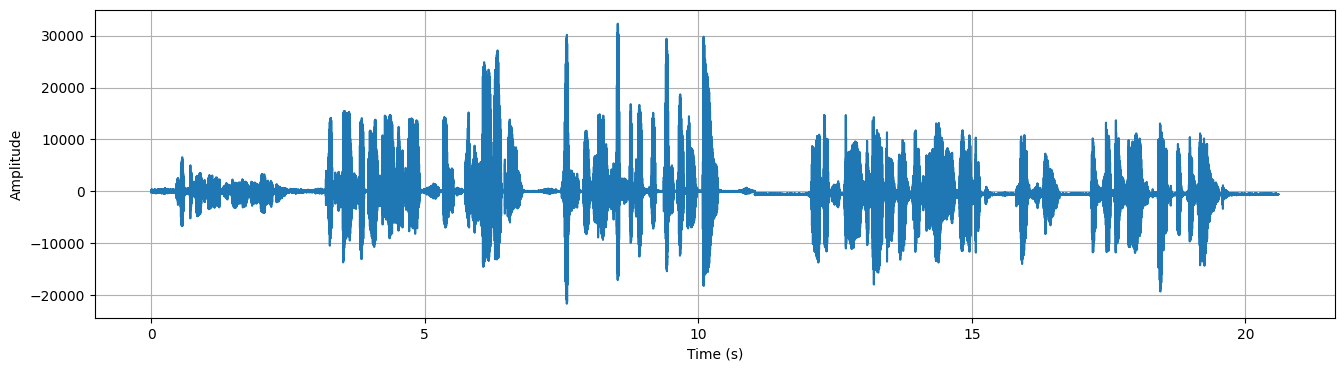

In [18]:
file_path = "out.wav"
sample_rate, signal = wav.read(file_path)
plotSignal(sample_rate, signal)

In [19]:
mfccs = librosa.feature.mfcc(y = np.float32(signal), sr=sample_rate, n_mfcc=30)
mfccs.shape, signal.shape

((30, 1775), (908554,))

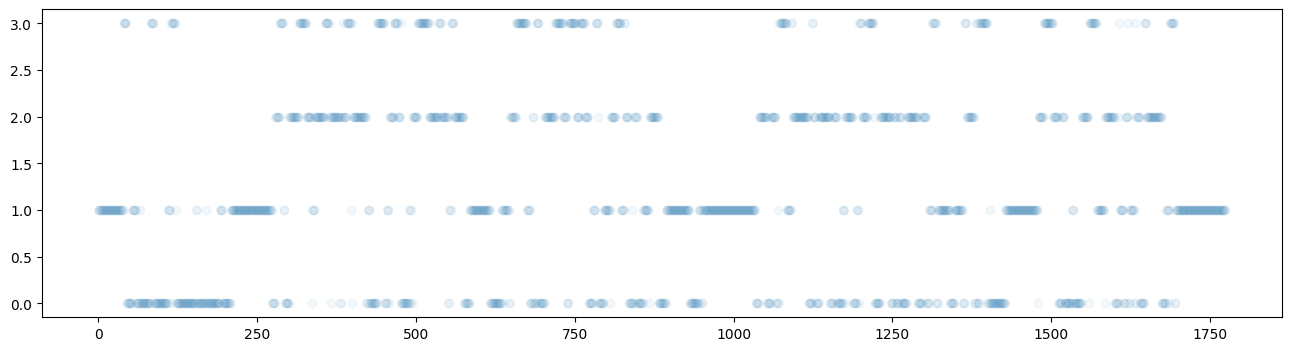

In [20]:
scaler = StandardScaler()
mfccs_scaled = mfccs.T
# mfccs_scaled = scaler.fit_transform(mfccs.T)
kmeans = KMeans(n_clusters=4)
# speaker_labels = kmeans.fit_predict(mfccs.T)
speaker_labels = kmeans.fit_predict(mfccs_scaled)
plt.figure(figsize=(16, 4))
plt.scatter(range(len(speaker_labels)), speaker_labels, alpha=0.05)

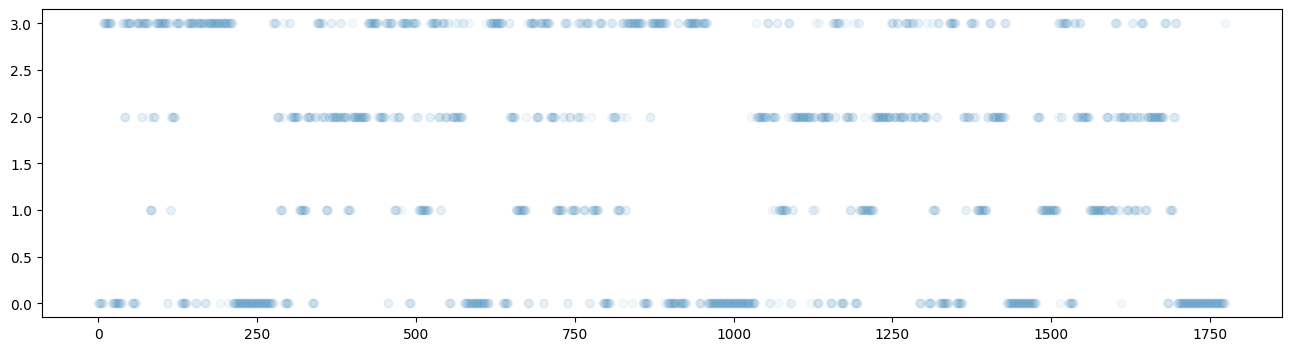

In [21]:
# GMM
gmm_model = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm = gmm_model.fit_predict(mfccs_scaled)

plt.figure(figsize=(16, 4))
plt.scatter(range(len(gmm)), gmm, alpha=0.05)

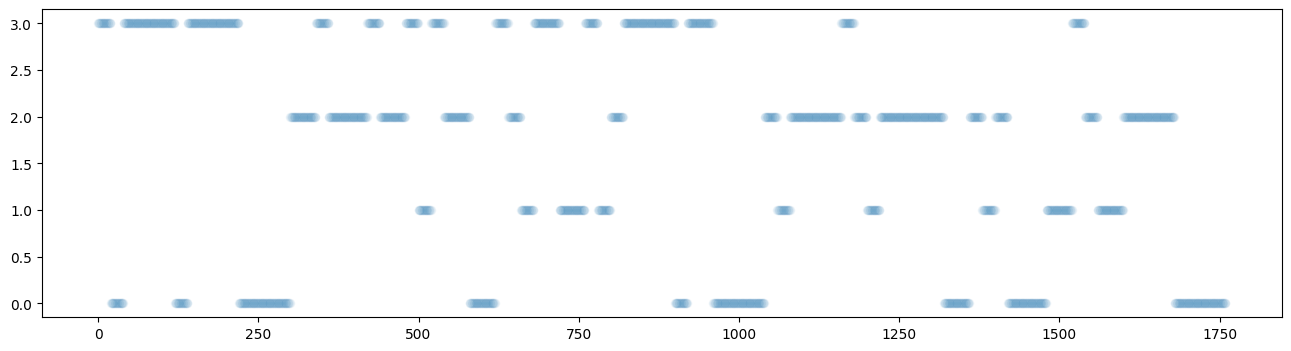

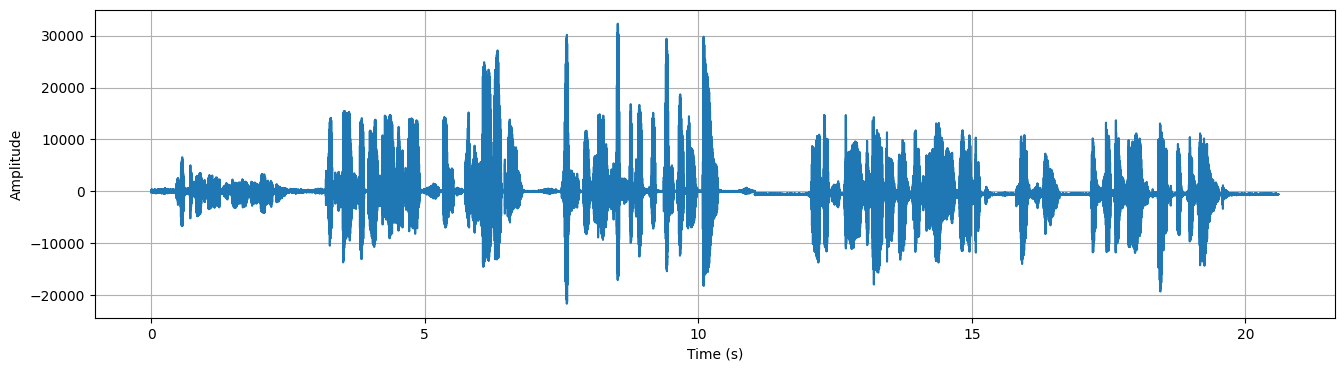

In [22]:
def windowSmoothing(data, w_size):
    prev_out = 0
    out = []
    for i in range(0, len(data)-w_size, w_size):
        window = data[i:i+w_size]
        d = dict.fromkeys(window, 0)
        for val in window :
            d[val] += 1
        max_key = None
        max_value = -1

        for key, value in d.items():
            if value > max_value:
                max_key = key
                max_value = value
            elif value == max_value:
                if key == prev_out:
                    max_key = key
        prev_out = max_key
        out.extend([max_key] * w_size)
    return out

smoothedGMM = windowSmoothing(gmm, 20)
plt.figure(figsize=(16, 4))
plt.scatter(range(len(smoothedGMM)), smoothedGMM, alpha=0.05)
plotSignal(sample_rate, signal)

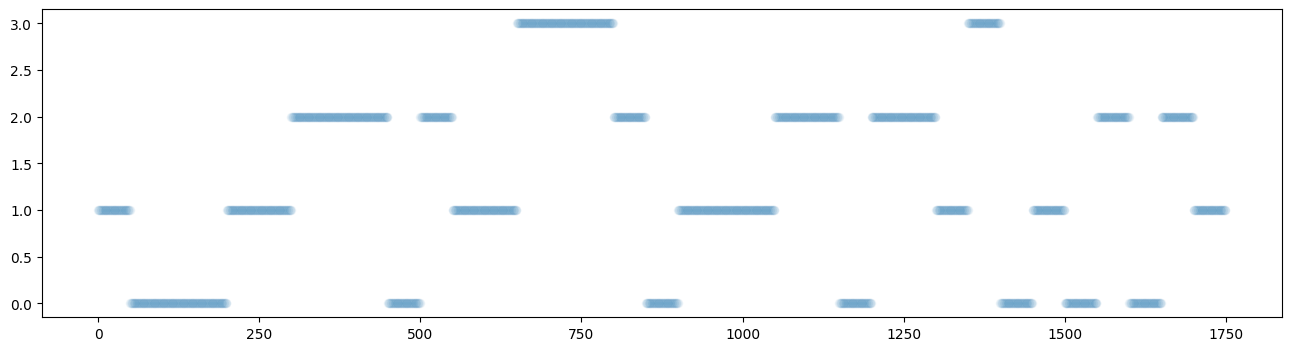

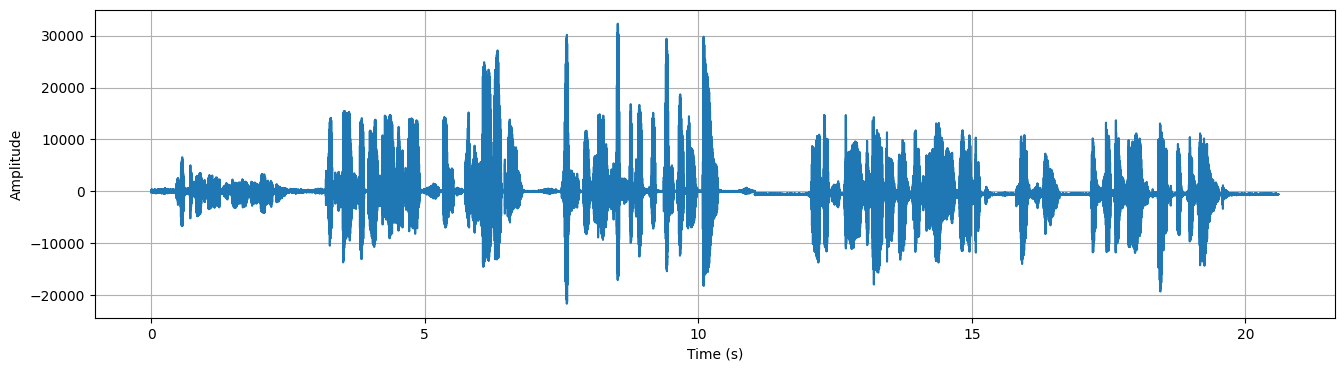

In [23]:
smoothedkmeans = windowSmoothing(speaker_labels, 50)
plt.figure(figsize=(16, 4))
plt.scatter(range(len(smoothedkmeans)), smoothedkmeans, alpha=0.05)
plotSignal(sample_rate, signal)

In [24]:
def perpendicularDist(m, c, x, y):
    return abs((m*x - y + c)/ np.sqrt(m**2 + 1))

def findBestClusterNumber(wcss_list : list):
    wcss_list_zip = list(zip(range(1,len(wcss_list) +1), wcss_list))
    m = (wcss_list_zip[0][1] - wcss_list_zip[-1][1] )/ (wcss_list_zip[0][0] - wcss_list_zip[-1][0])
    c = (wcss_list_zip[0][1] - (m*wcss_list_zip[0][0]))
    perpendicular_distances = []
    for i in wcss_list_zip:
        perpendicular_distances.append(perpendicularDist(m,c, i[0], i[1]))
    return np.argmax(perpendicular_distances)+1

Text(0.5, 1.0, 'kmeans')

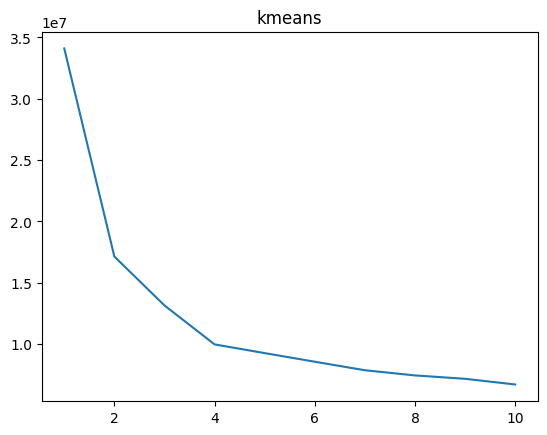

In [25]:
def getWCSS(data, max_k, model):
    wcss = []
    for i in range(1, max_k+1):
        if model == "kmeans":
            kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
            kmeans.fit(data) 
            wcss.append(kmeans.inertia_)
        elif model == "gmm":
            gmm = GaussianMixture(n_components=i, random_state=42)
            gmm.fit(data)
            wcss.append(-gmm.score(data) * len(data))
    return wcss

plt.plot(range(1, 11), getWCSS(mfccs_scaled, 10, model="kmeans"))
plt.title("kmeans")

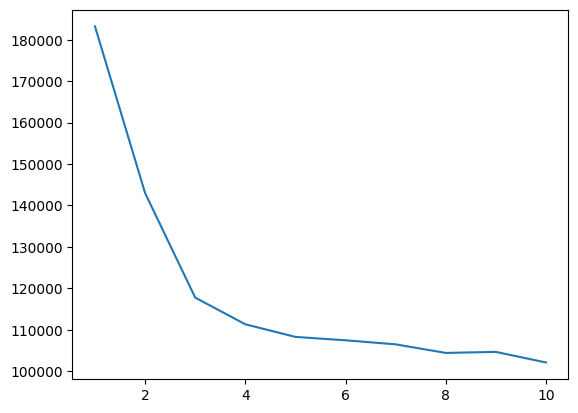

In [26]:

plt.plot(range(1, 11), getWCSS(mfccs_scaled, 10, model="gmm"))
plt.show()

In [27]:
print(findBestClusterNumber(getWCSS(mfccs_scaled, 10, model="kmeans")))
print(findBestClusterNumber(getWCSS(mfccs_scaled, 10, model="gmm")))

4
3


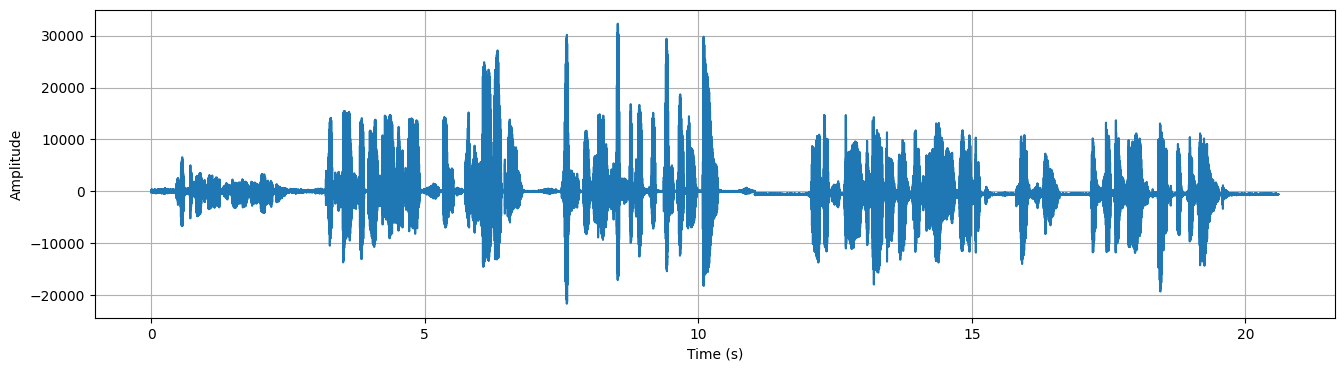

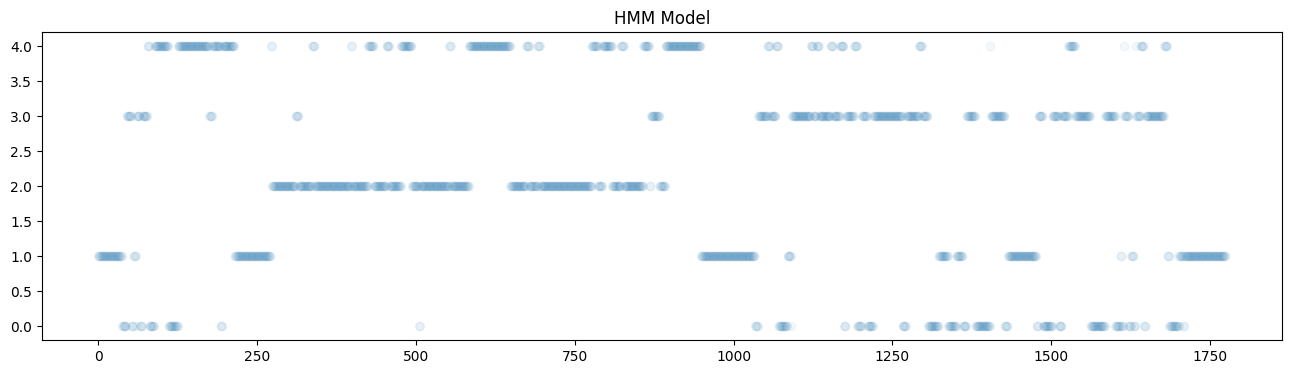

In [33]:
from hmmlearn import hmm
import numpy as np
# %matplotlib inline
from sklearn import datasets

#HMM Model
gm = hmm.GaussianHMM(n_components=5)
gm.fit(mfccs_scaled)
speaker_labels = gm.predict(mfccs_scaled)
#Plot
# color_dict = {0:"r",1:"g",2:"b"}
# color_array = [color_dict[i] for i in states]
# plt.scatter(range(len(ts_data)), ts_data, c=color_array)

plotSignal(sample_rate, signal)

plt.figure(figsize=(16, 4))
plt.title("HMM Model")
plt.scatter(range(len(speaker_labels)), speaker_labels, alpha=0.05)

In [28]:
r = sr.Recognizer()                                               
audio = sr.AudioFile("out.wav")
with audio as source:
    audio = r.record(source)                  
    result = r.recognize_google(audio)
print(result)

should be considered stronger than the other with both flappers and his tail as soon as I can this is my substitute for pistol and ball Robert story of the Bible by Jessi lime in Herbert part 3 the Shepherd boys fight with the giant
